<h1><center><b> Home Credit Default Risk</b></center></h1>### Submitted by: Michael Mendoza
#### November 30, 2023

<h1><center><b>Table of Contents</b></center></h1>

1. <a href="#1">Introduction</a>
2. <a href="#2">Data Preparation</a><br>
  2.1 <a href="#21">Import & Inspect Dataset</a><br>
  2.2 <a href="#24">Missing Value Imputation</a><br>
  2.3 <a href="#">Treating Low Variability Columns</a><br>
  2.4 <a href="#">Treating Multicolinearity </a><br>
  2.5 <a href="#27">Data Transformation - One Hot encoding</a><br>
  2.6 <a href="#32">Feature Engineering</a><br>
  2.7 <a href="#33">Data Split into Train & Test</a><br>
  2.8 <a href="#34">Feature Scaling</a><br>
3. <a href="#4">Modeling</a><br>
  3.1 <a href="#41">Logistic Regression</a><br>
  3.2 <a href="#42">Random Forest</a><br>
  3.3 <a href="#43">XGBoost</a><br>
  3.4 <a href="#46">ROC-AUC Function</a><br>
  3.5 <a href="#49">Explainable Model Predictions</a><br>
  3.6 <a href="#036">Feature Importance</a><br>
  3.7 <a href="#037">SHAP Analysis</a><br>
4. <a href="#5">Results</a><br>
  4.1 <a href="#51">Final Predictions</a><br>
  4.2 <a href="#52">Final Model Scores</a><br>
  4.3 <a href="#53">Final Interpretation & Model Selection Criteria</a><br>

# **1. Introduction** <a name='1'></a>

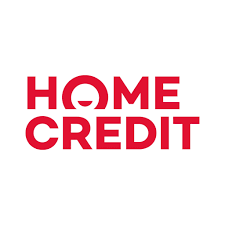






In this Notebook, we address a critical issue faced by many individuals who lack sufficient or any credit history, making it challenging for them to obtain loans. These underserved populations are often vulnerable to unscrupulous lenders. Home Credit, a consumer finance firm, is dedicated to promoting financial inclusion by providing loans to this unbanked population. However, this noble effort comes with a significant risk of loan defaults.

To mitigate this risk and ensure that deserving clients are not denied access to credit, Home Credit seeks to leverage historical loan application data to predict whether an applicant is likely to repay the loan or face difficulties in repayment. This prediction problem falls under the category of supervised predictive classification, as we have access to historical labeled data, and the target variable is binary, with values of 0 and 1 indicating whether a potential customer will repay the loan on time or encounter repayment challenges.

To achieve this, we will employ various machine learning techniques, including Logistic Regression and ensemble methods, to extract a list of customers with higher probabilities of loan repayment. Additionally, our prediction models will incorporate alternative data sources such as telco and transactional information to enhance the accuracy of our predictions. This Jupyter Notebook serves as a comprehensive guide to our data analysis, model development, and evaluation processes as we work towards improving lending decisions and advancing financial inclusion efforts.

# **2. Data Preparation** <a name="2"></a>

### **2.1 Import & Inspect Dataset** <a name="21"></a>

In [1]:
# importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Setting the warnings to be ignored
warnings.filterwarnings('ignore')

In [2]:
application_train = pd.read_csv("application_train.csv")
application_train.shape

(307511, 122)

In [3]:
# correlation matrix
cor = pd.DataFrame(application_train.corr(numeric_only=True))
cor = cor.sort_values('TARGET',ascending=False)
cor = cor.iloc[1:,1]

In [4]:
# Modifying the default row properties to display more number of rows
pd.set_option('display.max_rows', 70)

# missing values
missing_value = (application_train.isnull().mean() * 100).round()

# Create a new DataFrame to display the results
missing_info = pd.DataFrame({'Column Name': missing_value.index, 'Missing Percentage': missing_value.values})

# missing_info[missing_info['Missing Percentage']>0].sort_values('Missing Percentage',ascending=False)

In [5]:
# Displaying column missing value % along with its correlation with the target variable
cor = pd.DataFrame(cor)
missing_cor_df = pd.merge(missing_info, cor, left_on='Column Name', right_on = cor.index)

In [6]:
# Extracting columns with missing value percent greater than 48
missing_cor_df = missing_cor_df[missing_cor_df['Missing Percentage'] >= 48]
missing_cor_columns = missing_cor_df[missing_cor_df['Column Name'] != 'EXT_SOURCE_1']['Column Name']

In [7]:
# dropping columns with missing value percent greater than 48
application_train_clean = application_train.drop(columns=missing_cor_columns, axis=1)
application_train_clean.shape

(307511, 78)

### **2.2 Missing Value Imputation**



In [8]:
for column in application_train_clean.columns:
    if application_train_clean[column].dtype == 'object':
        application_train_clean[column].fillna(application_train_clean[column].mode()[0], inplace=True)

for column in application_train_clean.columns:
    if application_train_clean[column].dtype == 'float':
        application_train_clean[column].fillna(application_train_clean[column].median(), inplace=True)

In [9]:
application_train_clean.isna().sum().sum()

0

###  **2.3 Treating Low Variability columns**

Few columns have a very large proportion of values having the same value. These columns do not help for model development as they dont offer any variability and can safely be removed. The basis of selecting the columns to remove is unique value count less than 3 and imbalance proportion greater than 0.98:



In [10]:
selected_columns = []

# displaying columns along with a proportion of the unique values
for column in application_train_clean.columns:
    unique_values = application_train_clean[column].value_counts()
    total_count = len(application_train_clean)
    if len(unique_values) < 3: # Unique values less than 3 in a column
        proportions = unique_values / total_count
        if any(proportions > 0.98):  # Check if any proportion is above 0.98
            column_info = {
                "Column": column,
                "Proportions": proportions
            }
            selected_columns.append(column_info['Column'])
            # print(f"Column: {column}")
            # print("Proportions:")
            # print(proportions)
            # print("\n")

In [11]:
len(selected_columns)

21

In [12]:
# Dropping the selected columns with less variability
application_train_clean = application_train_clean.drop(columns=selected_columns, axis=1)
application_train_clean.shape

(307511, 57)

### **2.4 Treating Multicollinearity**

In [13]:
corr_matrix = application_train_clean.corr(numeric_only=True)
threshold = 0.7

# Find the pairs of variables with a correlation greater than the threshold
multicollinear_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            multicollinear_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Display the multicollinear pairs
print("Multicollinear Pairs:")
for pair in multicollinear_pairs:
  print(pair)

Multicollinear Pairs:
('CNT_CHILDREN', 'CNT_FAM_MEMBERS')
('AMT_CREDIT', 'AMT_ANNUITY')
('AMT_CREDIT', 'AMT_GOODS_PRICE')
('AMT_ANNUITY', 'AMT_GOODS_PRICE')
('DAYS_EMPLOYED', 'FLAG_EMP_PHONE')
('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION')
('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY')
('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE')
('DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE')


In [14]:
# Calculate the correlation of the multicollinear pairs with the 'TARGET' variable
correlation_with_target = {}
for pair in multicollinear_pairs:
    corr_column1 = application_train_clean[pair[0]].corr(application_train_clean['TARGET'])  # Calculate correlation with 'TARGET' for column 1
    corr_column2 = application_train_clean[pair[1]].corr(application_train_clean['TARGET'])  # Calculate correlation with 'TARGET' for column 2
    correlation_with_target[pair] = (corr_column1, corr_column2)

# Display the multicollinear pairs and their correlations with 'TARGET'
print("Multicollinear Pairs and Their Correlations with 'TARGET':")
for pair, corrs in correlation_with_target.items():
    print(f"Pair: {pair}, Correlation with 'TARGET' - Column 1: {corrs[0]:.2f}, Column 2: {corrs[1]:.2f}")

Multicollinear Pairs and Their Correlations with 'TARGET':
Pair: ('CNT_CHILDREN', 'CNT_FAM_MEMBERS'), Correlation with 'TARGET' - Column 1: 0.02, Column 2: 0.01
Pair: ('AMT_CREDIT', 'AMT_ANNUITY'), Correlation with 'TARGET' - Column 1: -0.03, Column 2: -0.01
Pair: ('AMT_CREDIT', 'AMT_GOODS_PRICE'), Correlation with 'TARGET' - Column 1: -0.03, Column 2: -0.04
Pair: ('AMT_ANNUITY', 'AMT_GOODS_PRICE'), Correlation with 'TARGET' - Column 1: -0.01, Column 2: -0.04
Pair: ('DAYS_EMPLOYED', 'FLAG_EMP_PHONE'), Correlation with 'TARGET' - Column 1: -0.04, Column 2: 0.05
Pair: ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'), Correlation with 'TARGET' - Column 1: 0.06, Column 2: 0.06
Pair: ('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION'), Correlation with 'TARGET' - Column 1: 0.01, Column 2: 0.00
Pair: ('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'), Correlation with 'TARGET' - Column 1: 0.05, Column 2: 0.03
Pair: ('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'),

The above output shows that these highly collinear column pairs have poor correlation with the target variable. But correlation of 0.03 can be considered for this dataset. Removing only columns with less than 0.03 but excluding 'CNT_FAM_MEMBERS', 'AMT_ANNUITY' as these appear very frequently in the credit risk domain.

In [15]:
# Dropping multicollinear columns with correlation less than 0.03
drop_columns = ['CNT_CHILDREN', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION','OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']

application_train_final = application_train_clean.drop(drop_columns, axis=1)
application_train_final.shape

(307511, 52)

# **3. Data Preparation** <a name="3"></a>

### **2.5 Data Transformation - One Hot encoding** <a name="31"></a>

There are 16 categorical variables in the dataset that needs to be converted to numeric values to be able to apply most of the ML models. Using One Hot Encoding to encode these 16 predictors:

In [16]:
#Get Dummies
application_train_final_bckup = application_train_final # storing the final application_train_final to a temp variable for backup
application_train_final = pd.get_dummies(application_train_final)

In [17]:
application_train_final = application_train_final.drop(columns=['SK_ID_CURR','NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave','CODE_GENDER_XNA'], axis=1)

### **2.6 Feature Engineering**<a name="32"></a>


After having performed a detailed research on credit risk business operations and customer loan application evaluation, and and extensive trial and error, we have identified the below few features to be valuable to credit risk domain which have helped improve model AUC.

*   CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
*   ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
*   CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due)
*   DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age








---



In [18]:
application_train_final['CREDIT_INCOME_PERCENT'] = application_train_final['AMT_CREDIT'] / application_train_final['AMT_INCOME_TOTAL']
application_train_final['ANNUITY_INCOME_PERCENT'] = application_train_final['AMT_ANNUITY'] / application_train_final['AMT_INCOME_TOTAL']
application_train_final['CREDIT_TERM'] = application_train_final['AMT_ANNUITY'] / application_train_final['AMT_CREDIT']
application_train_final['DAYS_EMPLOYED_PERCENT'] = application_train_final['DAYS_EMPLOYED'] / application_train_final['DAYS_BIRTH']

### **2.7 Data Split into Train & Test**<a name="33"></a>


The data was split into training and testing sets using the `train_test_split` function from scikit-learn with 80 and 20 % ratio

*   Training Set (X_train and y_train): This set will be used for training machine learning models and tuning hyperparameters.
*   Testing Set (X_test and y_test): This set will be reserved for evaluating the performance of our models. It helps us understand how well the model generalizes to new, unseen data.






In [19]:
from sklearn.model_selection import train_test_split

# As descibed above cleaning the predictor names to not contain any special characters and spaces.

def clean_feature_names(df):
    df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)  # Replace non-alphanumeric characters with underscores
    return df

application_train_final = clean_feature_names(application_train_final)

# Data Split
X = application_train_final.loc[:, application_train_final.columns != 'TARGET']
y = application_train_final['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (246008, 174)
y_train shape: (246008,)
X_test shape: (61503, 174)
y_test shape: (61503,)


### **2.8 Feature Scaling**<a name="34"></a>

In the below step, we did Feature scaling('Min-Max scaling') to transform and rescale our features to ensure that they all fall within a similar range [0-1], to prevent certain features from dominating others, i.e each feature has equal influence on the model during model training






In [20]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation or test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
X_test_scaled.shape

(246008, 174)


(61503, 174)

We have used 'norm' function for feature normalization with both StandardScaler and MinMaxScaler. It helps to select the desired normalization method based on the 'norm' parameter.

*   If 'norm' is set to 1, StandardScaler is used. StandardScaler scales features to have a mean of 0 and a standard deviation of 1.
*   If 'norm' is set to 0, MinMaxScaler is used. MinMaxScaler scales features to fall within the [0, 1] range.









In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def norm (norm, train):
  if norm ==1:
    scale = StandardScaler()

  else:
    scale = MinMaxScaler()

  norm = scale.fit_transform(train)
  return norm

train_norm = norm(1, X_train)
test_norm = norm(1, X_test)


# **3. Modeling** <a name="4"></a>

In the modeling phase of our project, we employ a range of machine learning techniques to predict home loan default risk accurately and efficiently. The models selected for this task include logistic regression, XGBoost, LightGBM, Neural Net and Random Forest. Each model is configured with optimized hyperparameters to maximize predictive performance.

- **Logistic Regression**: We have chosen logistic regression as one of the models for this task due to its simplicity and interpretability. It is employed when the dependent variable is categorical, representing two classes (binary classification) or more(multinomial classification).Logistic Regression models the probability that a given instance belongs to a particular class i.e, It serves as a fundamental baseline model to assess the predictive performance in predicting home loan defaults.

- **Random Forest**:  Random Forest is a machine learning model that combines multiple decision trees to make predictions. It takes a majority vote from the predictions of individual decision trees to improve accuracy and reduce overfitting.

- **XGBoost**: XGBoost is chosen for its predictive accuracy, ability to capture complex non-linear relationships in the data, preventing overfitting, and feature importance analysis.


To assess the model's predictive performance, we calculate two key metrics:
- **AUC (Area Under the Receiver Operating Characteristic Curve)**: The AUC score provides an indication of the model's ability to discriminate between positive and negative cases.
- **Accuracy**: Accuracy measures the proportion of correctly predicted outcomes in the test data.

Although we will be displaying accuracy for the tuned models just to verify that the accuracy is close to the majority class accuracy, the final best model will be selected based on the highest AUC and Kaggle score.


### **3.1 Logistic Regression** <a name="41"></a>

Logistic Regression ML method is senstive to unscaled data and class imbalance. Lets call the norm function to scale the numeric variables and use class_weight 'balanced' as a parameter.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Logistic Regression model
logistic_regression = LogisticRegression(max_iter = 100,random_state=42, class_weight = 'balanced')

# Fit the model on the scaled training data
logistic_regression.fit(train_norm, y_train)

y_train_pred = logistic_regression.predict(train_norm)
# Predict on the scaled test data
y_pred = logistic_regression.predict(test_norm)

# AUC & Accuracy
lg_roc_auc_train = roc_auc_score(y_train, y_train_pred)
lg_roc_auc_test = roc_auc_score(y_test, y_pred)
lg_accuracy = accuracy_score(y_test, y_pred)

print("Logistic Regression Train AUC:", lg_roc_auc_train)
print("Logistic Regression Test AUC:",lg_roc_auc_test)
print("Logistic Regression Accuracy:",lg_accuracy)

Logistic Regression Train AUC: 0.6852425399744705
Logistic Regression Test AUC: 0.6829560963065265
Logistic Regression Accuracy: 0.6883729248979724


AUC & accuracy scores of 0.68 explains that the model can make some distinctions, but it's not very reliable at classifying non loan default from those of repayment difficulties.

### **3.2 Random Forest** <a name="42"></a>

Random Forest being a tree based model, does not require feature scaling and can even handle multi-coollinear variables. Let's run a grid search to identify the best set of hyperparameters for the best AUC score.

### **Random Forest Tuning through Cross Validation/Grid Search**

**Cross-Validation :** It is a resampling technique that provides a robust assessment of a model's performance. It provides a better understanding of a model's generalization and helps identify issues like overfitting and underfitting.

For cross-validation we used k-fold cross-validation technique where the dataset(application_train) is divided into k equal-sized subsets or folds (k=3 in our case). The model is trained and evaluated K times, with each folding serving as the validation set once, and the remaining folds used for training. This process provides K different esimates of the model's performance, which are typically averaged to obtain a more reliable assessment.

**Tuning :**  For hyperparameter tuning, we used Grid search as it is effective in finding the best hyperparameters and also validate for any over-fitting. Here we defined a range of values for each hyperparameter of interest and using AUC score as the selection metric. Grid search then explores all the possible combinations provided. We can then call the *best_params_* method to obtain the set of hyperparameters with the highest AUC score.

In [23]:
'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = {
     'n_estimators': [50, 100, 200],
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                            cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
'''

'\nfrom sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\n\nparam_grid = {\n     \'n_estimators\': [50, 100, 200],\n     \'max_features\': [\'auto\', \'sqrt\', \'log2\'],\n     \'max_depth\': [None, 10, 20, 30],\n     \'min_samples_split\': [2, 5, 10],\n     \'min_samples_leaf\': [1, 2, 4]\n}\n\nrf = RandomForestClassifier()\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid,\n                            cv=3, n_jobs=-1, verbose=2, scoring=\'roc_auc\')\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nprint("Best parameters found: ", best_params)\n'

**Note:** CV and Grid Search ran on local machine.<br><br>
Best Params Results:<br>
max_depth = 20<br>
max_features = 'sqrt'<br>
min_samples_leaf = 4<br>
min_samples_split = 5<br>
n_estimators = 200<br>

### **Tuned Random Forrest**





Applying the set of best parameters obtained by tuning to make final predictions:

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

#APLLYING BEST PARAMETERS
rf_model = RandomForestClassifier(max_depth = 20,
                            max_features = 'sqrt',
                            min_samples_leaf = 4,
                            min_samples_split = 5,
                            n_estimators = 200)
rf_model.fit(X_train, y_train)

# Predict probabilities for both training and test sets
y_train_pred_prob = rf_model.predict_proba(X_train)[:, 1]
rf_y_final = rf_model.predict_proba(X_test)[:, 1]
y_test_pred = rf_model.predict(X_test)

# Calculate ROC AUC for the training set
rf_roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Calculate AUC & Accuracy for the test set
rf_roc_auc = roc_auc_score(y_test, rf_y_final)
rf_accuracy = accuracy_score(y_test, y_test_pred)


# Print the AUC & Accuracy scores
print("Tuned Random Forrest ROC AUC (Training):", rf_roc_auc_train)
print("Tuned Random Forrest ROC AUC (Test):", rf_roc_auc)
print("Tuned Random Forrest Accuracy:", rf_accuracy)

Tuned Random Forrest ROC AUC (Training): 0.9782158512400287
Tuned Random Forrest ROC AUC (Test): 0.7472969773887663
Tuned Random Forrest Accuracy: 0.9195323805342829


This tuned Random Forest scored 0.747 on kaggle which showed better performance than the logistic regresion model. Accuracy and AUc shows high potential on the Training data but not as high as on the Test data.

Test accuracy score of 0.9195 explains that the model is able to correctly predict in approximately 91.95% of the cases.

### **3.3 XGBoost** <a name="43"></a>

XGboost also being a tree based model, does not require feature scaling and can even handle multi-coollinear variables. Let's run a grid search to identify the best set of hyperparameters for the best AUC score.

### **XGBoost Tuning through Cross Validation/Grid Search**

In [25]:
'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

#Cross Validation with XGBoost
xgb_model = XGBClassifier()
#cross_val_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
#print("Mean CV Accuracy:", cross_val_scores.mean())

#Hyperparameter Tuning with GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

#Cross-Validation with XGBoost
grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
'''

'\nfrom sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.metrics import accuracy_score\n\n#Cross Validation with XGBoost\nxgb_model = XGBClassifier()\n#cross_val_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=\'accuracy\')\n#print("Mean CV Accuracy:", cross_val_scores.mean())\n\n#Hyperparameter Tuning with GridSearchCV\nparam_grid = {\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [3, 4, 5],\n    \'subsample\': [0.8, 0.9, 1],\n    \'colsample_bytree\': [0.8, 0.9, 1]\n}\n\n#Cross-Validation with XGBoost\ngrid_search = GridSearchCV(xgb_model, param_grid, scoring=\'roc_auc\', cv=5, n_jobs=-1, verbose=1)\ngrid_search.fit(X_train_resampled, y_train_resampled)\n\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n'

**Note:** CV and Grid Search ran on local machine.<br><br>
Best Params Results:<br>
colsample_bytree = 0.9<br>
learning_rate = 0.1<br>
max_depth = 5<br>
n_estimators = 200<br>
subsample = 1<br>

### **Tuned XGBOOST Model**

Applying the set of best parameters obtained by tuning to make final predictions:

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# XGBoost classifier Initializing with the specified parameters
xgb_model = XGBClassifier(colsample_bytree = 0.9,
                          learning_rate = 0.1,
                          max_depth = 5,
                          n_estimators = 200,
                          subsample = 1)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]

# Make predictions on the test set
xgb_y_pred = xgb_model.predict_proba(X_test)[:, 1]  # Use predict_proba to get probability scores for the positive class
y_pred = xgb_model.predict(X_test)

xgb_train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)

# Calculate the ROC-AUC score on the test set
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred)

# AUC & Accuracy
print(f'Tuned XGB Train ROC-AUC Score: {xgb_train_roc_auc}')
print(f'Tuned XGB Test ROC-AUC Score: {xgb_roc_auc}')
print(f'Tuned XGB Accuracy Score: {xgb_accuracy}')

Tuned XGB Train ROC-AUC Score: 0.8103609283835761
Tuned XGB Test ROC-AUC Score: 0.7689128924057462
Tuned XGB Accuracy Score: 0.9202965708989805


This tuned XGB model scored 0.758 on Kaggle which is the highest so far we gotten in unsampled data. It is most likely will be the chosen model solution but will have to explore more on some sampling datasets. XGBoost is considered blackbox model but with some other packages we can explore the predictors which will be shown and discussed later in the notebook.

### **3.4 ROC-AUC Curve** <a name="46"></a>

ROC-AUC curve is used to evaluate and visualize the trade-offs between the model's true positive rate (sensitivity) and its false positive rate (1-specificity) at different classification thresholds.

An ideal classifier would have a ROC curve that reaches the top-left corner, indicating high sensitivity and low false positive rate across all threshold values.

Below is the plot summarizing the ROC curve along with the AUC score for all the models.

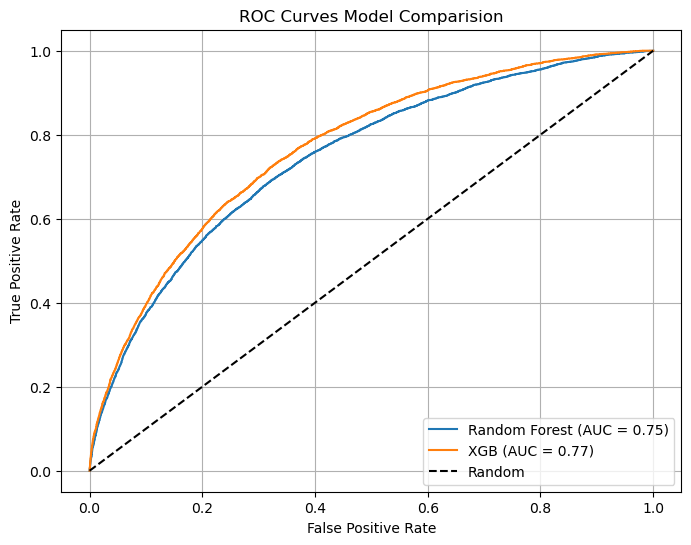

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

X = application_train_final.loc[:, application_train_final.columns != 'TARGET']
y = application_train_final['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a list of models and their corresponding labels (Team: add all your models here)
models = [(rf_model, "Random Forest"), (xgb_model, "XGB")]
plt.figure(figsize=(8, 6))

# Plot ROC curves for all models
for model, label in models:
  y_prob = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')



# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', label="Random")

# Customize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Model Comparision")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


We observe similar ROC-AUC score and pattern for XGB, LGB and Random Forest models.

###  **3.5 Explainable Model Predictions** <a name="49"></a>

The use of black box models such as Random Forest, Boosting methods and Neural Networks although increases prediction accuracy, however practical applications for instance in prediciton loan defaults for new credit applications raises concerns over model fairness and the need of it's basis for judgement. Any bias identified in the historical data would be carry forwarded posing a serious risk of model learning this unintended cognitive biases or real-life prejudices leading to rejecting deserving credit applications. Hence, it is important for us to not only interpret the model results but also be able to explain the reason for the model making a particular decision.

Feature Importance method of models allows us to glance the most influential predictor variables on the target variable. Let's look at the top 20 predictors:

### **3.6 Feature Importance**  <a name="036"></a>

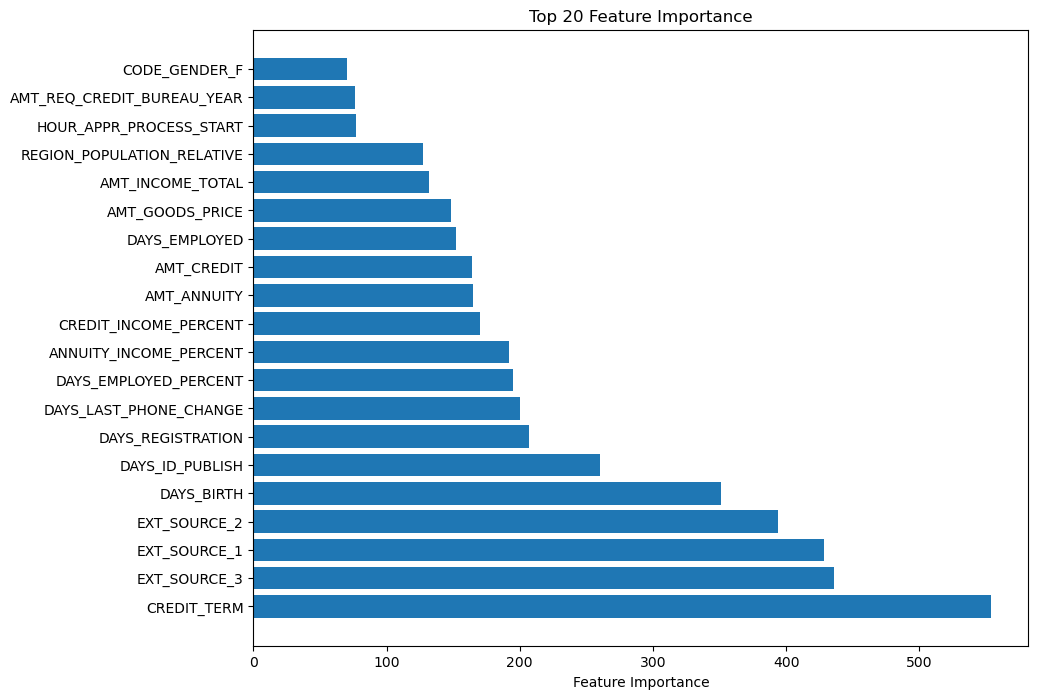

In [28]:
# Plot the feature importance chart

importance = xgb_model.get_booster().get_fscore()
top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]

feature_names, feature_importance = zip(*top_features)

# Plot the feature importance chart for the top 25 features
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_names)), feature_importance, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance')
plt.show()

#xgb.plot_importance(xgb_model, importance_type='weight')  # You can change importance_type as needed
#plt.show()

In [29]:
s = sum(feature_importance)

norm_imp = tuple(value / s for value in feature_importance)

# Print the result
print(norm_imp)

(0.1231658514895509, 0.09693196976433971, 0.09515340151178302, 0.08759448643841708, 0.07803468208092486, 0.057803468208092484, 0.0460204535349044, 0.044464206313917294, 0.04335260115606936, 0.0426856380613606, 0.0377945753668297, 0.03668297020898177, 0.03646064917741218, 0.03379279679857715, 0.0329035126722988, 0.029346376167185415, 0.028234771009337484, 0.01711871943085816, 0.016896398399288574, 0.015562472209871054)


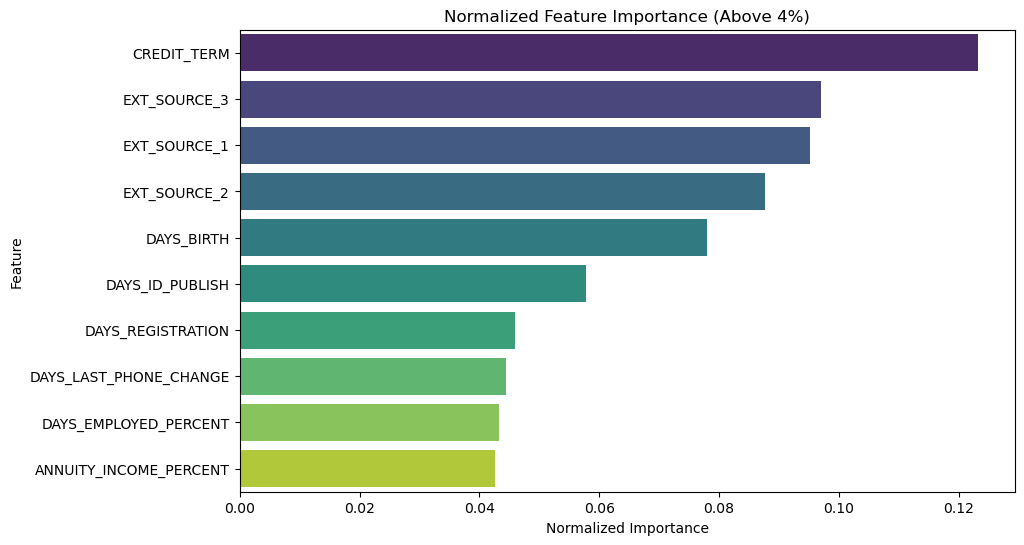

In [30]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Normalized Importance': norm_imp})

filtered_importance_df = importance_df[importance_df['Normalized Importance'] > 0.04]

# Sort the DataFrame by importance
filtered_importance_df = filtered_importance_df.sort_values(by='Normalized Importance', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Normalized Importance', y='Feature', data=filtered_importance_df, palette='viridis')
plt.title('Normalized Feature Importance (Above 4%)')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()

The problem with the above approach is that it is not tailored to individual credit applications. The above 20 feaures are the estimated important predictors obtained using the entire training data. While assessing credit applications, companies like Home Credit are responsible to provide an appropriate reason for loan rejection that is specific and customized to that indicvidual. This is not possible directly with black box model results but packages such as SHAP has empowered us to look beyond just the model prediction.

### **3.7 SHAP Analysis**  <a name="037"></a>

The SHAP (SHapley Additive exPlanations) package in Python is a powerful tool for model interpretability and feature importance analysis. As discuessed earlier, SHAP's key strengths is its ability to explain individual predictions. For a given data point, SHAP values break down the prediction into contributions from each feature, helping us understand why the model made a specific decision. SHAP values are invaluable for diagnosing model behavior as well as examine SHAP values for problematic predictions or cases where the model's performance is suboptimal. This addresses the concerns of bias, outliers, or data quality problems.

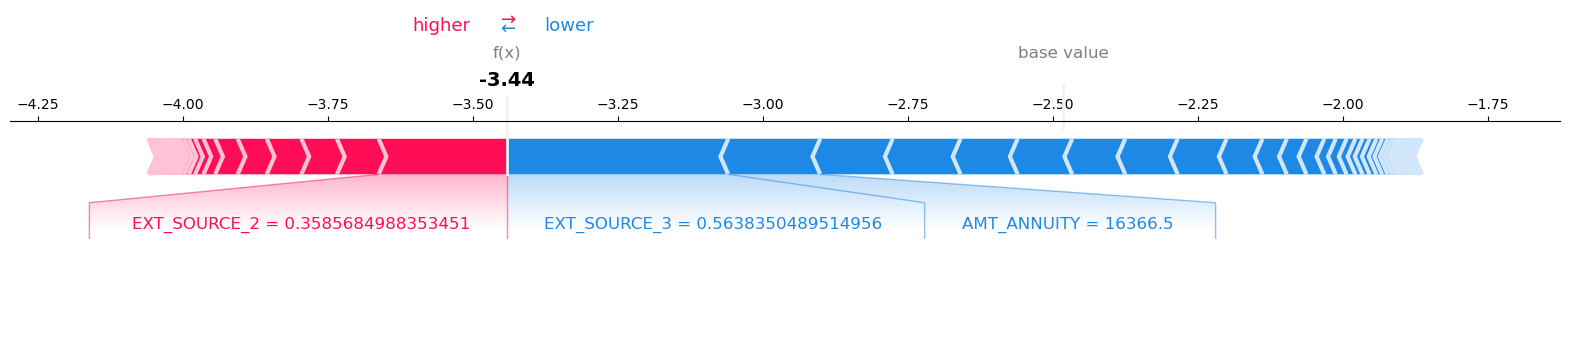

In [31]:
import shap
import matplotlib.pyplot as plt

model = xgb_model

# Load your data
X = X_train

# Choosing the first data point in train to explain the prediction
data_point = X.iloc[0]

# Initialize the explainer for the model
explainer = shap.TreeExplainer(model)

# Calculate the SHAP values for the selected data point
shap_values = explainer.shap_values(X)

# # Display the force plot
shap.force_plot(explainer.expected_value, shap_values[0], data_point,matplotlib=True)
plt.show()

Shap Force Plot here shows how the various features in our loan prediction model influence its model predictions. The size and direction of the arrows represent the magnitude and direction of the impact of each feature. The base value of nearly -2.4 shap value is essentially the prediction the model would make if no features had any impact. Base value almost being equal to the shap value indicates that the predictor variables have a neutral overall effect on the predicted outcome.

From the Force Plot, the features "EXT Source 2" with a value of 0.21, "Region Rating Client with City" with a value of around 3 and "Amount Goods price" with value of 180000 have positive SHAP values, meaning that they have a positive impact on the model's outcome of whether a client will have payment difficulties. This could mean that having a higher loan annuity or credit amount increases the chance of the model predicting that the client will have loan repayment difficulties.

The features EXT_SOURCE_3 with 0.544 has a negative impact on the model's prediction. This means that having a higher normalized score from an external data source or a higher price of the goods for which the loan is given decreases the chance of the model predicting that the client will have payment difficulties.

Hence, the insights from the force plot can be extremely handy for all the new loan applications where this model predictions can be backed with appropriate factual reasoning for approving/rejecting the loan. For instance, for the first row in the train set example that we have shown above, the loan application is approved because though the customer's External Source 3 might have hurt his chances but other factors such as External Source 2, the city where the client lives and the price of goods for this loan are good enough. Similarly, whenever the customer is rejected for a loan, based on this plot, the client can be informed on why he was declined.

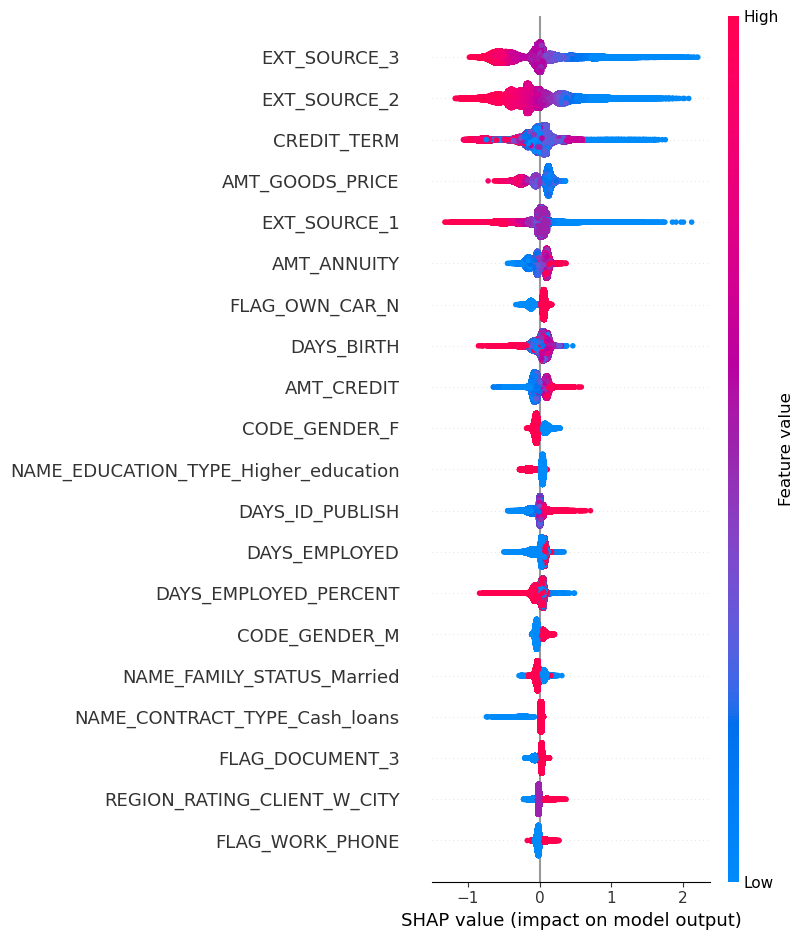

In [32]:
plt.figure(figsize=(4,6))
shap.summary_plot(shap_values, X_train)

*   SHAP analysis shows how the values of different features influence the model's predictions in a decreasing order of influence from top to bottom. From the summary plot, the features EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1 are inversely correlated to the target variable. This is aligned with our findings from the correlational analysis. Therefore, lower values for these features have a positive influence on the model outcome and push the predicted value higher meaning greater chance of repayment difficulty.
*   It is worth noting that, high values of credit term in most cases would lower the model predicted value but there are cases where the model could actually push the value predicted value higher. There could be other predictors influencing this decision and needs to be further investigated.

*   For the feature DAYS_ID_PUBLISH, higher values are associated with higher predicted outcomes. This shows that individuals who have been on the platform for a longer period of time are more likely to have higher outcomes. For the feature AMT_GOODS_PRICE, there is a cluster of instances with low values (blue points) with small but positive SHAP values. Instances with higher values (red points) extend further towards the left, suggesting that high goods price has a stronger negative impact on target than the positive impact of low goods price on target. Therefore, the model is more likely to predict lower outcomes for individuals with higher values of external sources and higher prices for goods.

Overall, by leveraging the above and other plots from SHAP, Home Credit can gain deeper insights into model behavior, build trust in AI systems, and make informed decisions based on model output making it a crucial tool in the field of interpretable machine learning and model explainability.





# **4. Results** <a name="5"></a>

### **4.1 Final Predictions** <a name="51"></a>

To predict how the models performs on unseen real world data, we must match the preictors that were used for the model training. Therefore, we apply the same data cleaning & preparation with the application_test dataset from kaggle.

In [33]:
application_test = pd.read_csv("application_test.csv")
skid = application_test['SK_ID_CURR']
application_test_clean = application_test.drop(columns=missing_cor_columns, axis=1)
application_test_clean.shape

(48744, 77)

In [34]:
# application_test.isna().sum()
for column in application_test_clean.columns:
    if application_test_clean[column].dtype == 'object':
        application_test_clean[column].fillna(application_test_clean[column].mode()[0], inplace=True)

for column in application_test_clean.columns:
    if application_test_clean[column].dtype == 'float':
        application_test_clean[column].fillna(application_test_clean[column].median(), inplace=True)

application_test_clean.isna().sum().sum()

# Dropping the selected columns with less variability
application_test_clean = application_test_clean.drop(columns=selected_columns, axis=1)
application_test_clean.shape

# Dropping multicollinear columns with correlation less than 0.03
drop_columns = ['SK_ID_CURR','CNT_CHILDREN','REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION','OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']

application_test_clean = application_test_clean.drop(drop_columns, axis=1)
application_test_clean.shape

#Get Dummies
application_test_clean_bckup = application_test_clean # storing the final application_train_final to a dummy variable
application_test_final = pd.get_dummies(application_test_clean)

application_test_final.shape

application_test_final_norm = norm(1,application_test_final)


application_test_final = clean_feature_names(application_test_final)


In [35]:
application_test_final['CREDIT_INCOME_PERCENT'] = application_test_final['AMT_CREDIT'] / application_test_final['AMT_INCOME_TOTAL']
application_test_final['ANNUITY_INCOME_PERCENT'] = application_test_final['AMT_ANNUITY'] / application_test_final['AMT_INCOME_TOTAL']
application_test_final['CREDIT_TERM'] = application_test_final['AMT_ANNUITY'] / application_test_final['AMT_CREDIT']
application_test_final['DAYS_EMPLOYED_PERCENT'] = application_test_final['DAYS_EMPLOYED'] / application_test_final['DAYS_BIRTH']
application_test_final_norm = norm(1,application_test_final)
application_test_final = clean_feature_names(application_test_final)

**Model predictions on application_test data**

In [36]:
# Tuned model predictions
logistic_y_final = logistic_regression.predict(application_test_final_norm)
rf_y_final = rf_model.predict_proba(application_test_final)[:, 1]
xgb_y_final = xgb_model.predict_proba(application_test_final)[:, 1]

### **4.2 Model Score Summary** <a name="52"></a>

AUC is the model evaluation metric chosen for selecting the best model. Below is the table that contains AUC scores with the train and test sets, down & smote sampled data, along with their respective kaggle scores

In [39]:
import pandas as pd

# Create a list of model names and their AUC scores
model_names = ["Logistic Regression","Random Forrest", "XG Boost"]
train_auc_scores = [lg_roc_auc_train, rf_roc_auc_train, xgb_train_roc_auc]
test_auc_scores = [lg_roc_auc_test, rf_roc_auc, xgb_roc_auc]
accuracy_scores = [lg_accuracy, rf_accuracy, xgb_accuracy]
kaggle_score = [0.637 ,0.735,0.758]


# Create a DataFrame to store the model names and AUC scores
score_summary = pd.DataFrame({'Model Name': model_names, 'Train AUC Score': train_auc_scores, 'Test AUC Score': test_auc_scores,'Test Accuracy Score':accuracy_scores, 'Kaggle Score':kaggle_score})

# Round all the scores to 2 decimals
score_summary = score_summary.round(3)

# Display the DataFrame as a table
pd.set_option('display.max_columns', 20)
pd.set_option('display.width',170)
print(score_summary)


            Model Name  Train AUC Score  Test AUC Score  Test Accuracy Score  Kaggle Score
0  Logistic Regression            0.685           0.683                0.688         0.637
1       Random Forrest            0.978           0.747                0.920         0.735
2             XG Boost            0.810           0.769                0.920         0.758


### **4.3 Final Model Selection Criteria** <a name="53"></a>

*   It is evident that all models exhibit higher AUC scores on the training data compared to the test data, indicating a potential issue with overfitting. Random Forest stands out with an exceptionally high training AUC score of 0.97, which is a strong indicator of overfitting.

*   XG Boost perform comparably well with Kaggle scores around 0.75. In contrast, Logistic Regression lags behind with a Kaggle score of 0.637, signifying its limitations in handling real-world, unseen data effectively.




##### **Overall, the best Kaggle score obtained is 0.758 with tuned XGBoost.**

## <center><a href='#1'>**Navigate to top**</a>